## N-PINN Re 100

In [1]:
import os
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.contour as contour
import pandas as pd
import scipy
import sklearn
import scipy.optimize as opt
import time
import pandas as pd

from tensorflow import keras
from pyDOE import lhs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

os.environ["CUDA_VISIBLE_DEVICES"]="-1"

seed = 1228 

os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPUs available: []


In [2]:
Re = 100
ub = 1

shape = 51
x_l, x_r = 0, 1
y_b, y_t = -1, 0

x = np.linspace(x_l, x_r, shape, endpoint=True)
y = np.linspace(y_b, y_t, shape, endpoint=True)

dx = x[1] - x[0]
dy = y[1] - y[0]

# create meshgrid
X, Y = np.meshgrid(x, y)
xy_train = np.hstack((
    X.flatten()[:, None],
    Y.flatten()[:, None],
    dx * np.ones_like(X.flatten()[:, None]),
    dy * np.ones_like(Y.flatten()[:, None])
))
xy_train = tf.Variable(xy_train, dtype=tf.float32)

# BC mask 
top    = tf.equal(xy_train[:,1:2], y_t)
bottom = tf.equal(xy_train[:,1:2], y_b)
left   = tf.equal(xy_train[:,0:1], x_l)
right  = tf.equal(xy_train[:,0:1], x_r)
bc_mask = tf.logical_or(tf.logical_or(top, bottom), tf.logical_or(left, right))

# check number of BC points
print("Total BC points:", tf.reduce_sum(tf.cast(bc_mask, tf.int32)).numpy())
print("Top BC points:", tf.reduce_sum(tf.cast(top, tf.int32)).numpy())
print("Right BC points:", tf.reduce_sum(tf.cast(right, tf.int32)).numpy())

Total BC points: 200
Top BC points: 51
Right BC points: 51


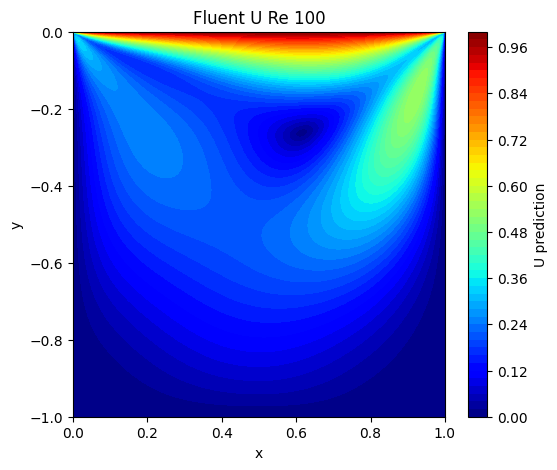

Reynolds Number: 100


In [7]:
U_ansys = pd.read_excel(f"../savedata {Re}/U_ansys Re {Re}.xlsx")

x_true = np.linspace(x_l,x_r,252)
y_true = np.linspace(y_b,y_t,252)
umag_true = np.array(U_ansys['magnitude'])/1
u_true = np.array(U_ansys['x-velocity'])/1

X_true,Y_true = np.meshgrid(x_true,y_true)
Umag_true = umag_true.reshape(X_true.shape)
U_true = u_true.reshape(X_true.shape)

# === Plot ===
plt.figure(figsize=(6,5))
plt.contourf(X_true, Y_true, Umag_true, levels=50, cmap="jet")
plt.colorbar(label="U prediction")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Fluent U Re {Re}")
plt.show()
plt.show()

print(f'Reynolds Number: {Re}')

Epoch     1 | Total Loss: 1.2335e+00 | PDE: 1.4352e-01 | BC: 1.0899e+00
Epoch   100 | Total Loss: 2.4412e-01 | PDE: 1.4069e-02 | BC: 2.3005e-01
Epoch   200 | Total Loss: 8.7703e-02 | PDE: 8.7230e-03 | BC: 7.8980e-02
Epoch   300 | Total Loss: 7.6220e-02 | PDE: 8.6717e-03 | BC: 6.7548e-02
Epoch   400 | Total Loss: 7.5880e-02 | PDE: 9.2015e-03 | BC: 6.6679e-02
Epoch   500 | Total Loss: 7.1430e-02 | PDE: 6.9592e-03 | BC: 6.4470e-02
Epoch   600 | Total Loss: 6.8290e-02 | PDE: 6.1613e-03 | BC: 6.2129e-02
Epoch   700 | Total Loss: 6.8186e-02 | PDE: 7.1182e-03 | BC: 6.1068e-02
Epoch   800 | Total Loss: 6.7349e-02 | PDE: 6.2022e-03 | BC: 6.1146e-02
Epoch   900 | Total Loss: 6.2655e-02 | PDE: 7.1765e-03 | BC: 5.5478e-02
Epoch  1000 | Total Loss: 7.2674e-02 | PDE: 1.6904e-02 | BC: 5.5769e-02
Epoch  1100 | Total Loss: 6.1662e-02 | PDE: 6.9060e-03 | BC: 5.4756e-02
Epoch  1200 | Total Loss: 6.1456e-02 | PDE: 6.9719e-03 | BC: 5.4484e-02
Epoch  1300 | Total Loss: 6.1257e-02 | PDE: 7.0115e-03 | BC: 5.4

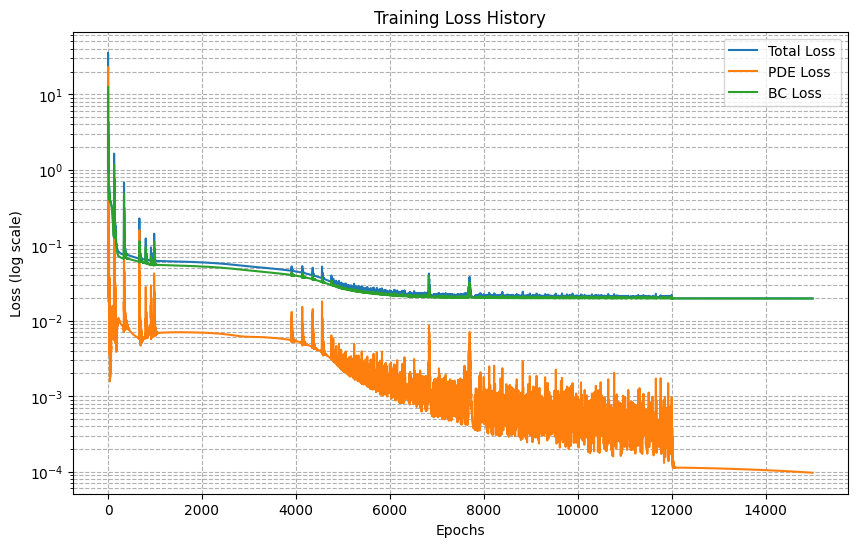

In [4]:
class Neural_Net(tf.keras.Model):


    def __init__(self, activations, x_input):
        
        super().__init__()

        # --- unpack x_input ---
        self.x  = x_input[:,0:1]
        self.y  = x_input[:,1:2]
        self.dx = x_input[:,2:3]
        self.dy = x_input[:,3:4]

        # --- BC mask using exact domain bounds ---
        self.top    = tf.equal(self.y, y_t)   # top boundary
        self.bottom = tf.equal(self.y, y_b)   # bottom boundary
        self.left   = tf.equal(self.x, x_l)   # left boundary
        self.right  = tf.equal(self.x, x_r)   # right boundary
        self.bc     = tf.logical_or(tf.logical_or(self.top, self.bottom),
                                    tf.logical_or(self.left, self.right))

        # --- Neural Network layers ---
        self.Layer_1 = tf.keras.layers.Dense(80, activation=activations)
        self.Layer_2 = tf.keras.layers.Dense(80, activation=activations)
        self.Layer_3 = tf.keras.layers.Dense(80, activation=activations)
        self.Layer_4 = tf.keras.layers.Dense(80, activation=activations)
        self.Layer_5 = tf.keras.layers.Dense(80, activation=activations)
        self.Output  = tf.keras.layers.Dense(3, activation='linear')

    # --- forward pass ---
    def call(self, inputs_vec):
        x = self.Layer_1(inputs_vec)
        x = self.Layer_2(x)
        x = self.Layer_3(x)
        x = self.Layer_4(x)
        x = self.Layer_5(x)
        return self.Output(x)

    # --- evaluate at given points ---
    def eval_point(self, x, y, dx, dy):
        inputs = tf.concat([x, y, dx, dy], axis=1)
        preds = self.call(inputs)
        return preds[:,0:1], preds[:,1:2], preds[:,2:3]   # u, v, p

    # --- generate outputs for neighbors ---
    def Output_NN(self):
        x, y, dx, dy = self.x, self.y, self.dx, self.dy

        u, v, p = self.eval_point(x, y, dx, dy)
        u_e, v_e, p_e = self.eval_point(x+dx, y, dx, dy)
        u_w, v_w, p_w = self.eval_point(x-dx, y, dx, dy)
        u_n, v_n, p_n = self.eval_point(x, y+dy, dx, dy)
        u_s, v_s, p_s = self.eval_point(x, y-dy, dx, dy)
        u_ee, v_ee, _ = self.eval_point(x+2*dx, y, dx, dy)
        u_ww, v_ww, _ = self.eval_point(x-2*dx, y, dx, dy)
        u_nn, v_nn, _ = self.eval_point(x, y+2*dy, dx, dy)
        u_ss, v_ss, _ = self.eval_point(x, y-2*dy, dx, dy)

        return (u, v, p,
                u_e, v_e, p_e, u_w, v_w, p_w,
                u_n, v_n, p_n, u_s, v_s, p_s,
                u_ee, v_ee, u_ww, v_ww,
                u_nn, v_nn, u_ss, v_ss)

    # --- numerical scheme with PDE & BC losses ---
    def Numerical_Scheme(self):
        (u, v, p,
         u_e, v_e, p_e, u_w, v_w, p_w,
         u_n, v_n, p_n, u_s, v_s, p_s,
         u_ee, v_ee, u_ww, v_ww,
         u_nn, v_nn, u_ss, v_ss) = self.Output_NN()

        dx, dy = self.dx, self.dy

        # --- face-centered interpolation ---
        u_ce, u_cw = 0.5*(u_e + u), 0.5*(u_w + u)
        v_cn, v_cs = 0.5*(v_n + v), 0.5*(v_s + v)
        p_ce, p_cw = 0.5*(p_e + p), 0.5*(p_w + p)
        p_cn, p_cs = 0.5*(p_n + p), 0.5*(p_s + p)

        px = (p_ce - p_cw)/dx
        py = (p_cn - p_cs)/dy
        div = (u_ce - u_cw)/dx + (v_cn - v_cs)/dy

        # --- 2nd-order upwind convection ---
        uem_uw2 = 1.5*u - 0.5*u_w
        uep_uw2 = 1.5*u_e - 0.5*u_ee
        uwm_uw2 = 1.5*u_w - 0.5*u_ww
        uwp_uw2 = 1.5*u - 0.5*u_e
        ue_uw2 = tf.where(tf.greater_equal(u_ce,0.0), uem_uw2, uep_uw2)
        uw_uw2 = tf.where(tf.greater_equal(u_cw,0.0), uwm_uw2, uwp_uw2)

        unm_uw2 = 1.5*u - 0.5*u_s
        unp_uw2 = 1.5*u_n - 0.5*u_nn
        usm_uw2 = 1.5*u_s - 0.5*u_ss
        usp_uw2 = 1.5*u - 0.5*u_n
        un_uw2 = tf.where(tf.greater_equal(v_cn,0.0), unm_uw2, unp_uw2)
        us_uw2 = tf.where(tf.greater_equal(v_cs,0.0), usm_uw2, usp_uw2)

        vem_uw2 = 1.5*v - 0.5*v_w
        vep_uw2 = 1.5*v_e - 0.5*v_ee
        vwm_uw2 = 1.5*v_w - 0.5*v_ww
        vwp_uw2 = 1.5*v - 0.5*v_e
        ve_uw2 = tf.where(tf.greater_equal(u_ce,0.0), vem_uw2, vep_uw2)
        vw_uw2 = tf.where(tf.greater_equal(u_cw,0.0), vwm_uw2, vwp_uw2)

        vnm_uw2 = 1.5*v - 0.5*v_s
        vnp_uw2 = 1.5*v_n - 0.5*v_nn
        vsm_uw2 = 1.5*v_s - 0.5*v_ss
        vsp_uw2 = 1.5*v - 0.5*v_n
        vn_uw2 = tf.where(tf.greater_equal(v_cn,0.0), vnm_uw2, vnp_uw2)
        vs_uw2 = tf.where(tf.greater_equal(v_cs,0.0), vsm_uw2, vsp_uw2)

        u_ux = (u_ce*ue_uw2 - u_cw*uw_uw2)/dx
        v_uy = (v_cn*un_uw2 - v_cs*us_uw2)/dy
        u_vx = (u_ce*ve_uw2 - u_cw*vw_uw2)/dx
        v_vy = (v_cn*vn_uw2 - v_cs*vs_uw2)/dy

        # --- diffusion (central 2nd order) ---
        Uxx = (u_e - 2.0*u + u_w)/(dx**2)
        Uyy = (u_n - 2.0*u + u_s)/(dy**2)
        Vxx = (v_e - 2.0*v + v_w)/(dx**2)
        Vyy = (v_n - 2.0*v + v_s)/(dy**2)

        # --- PDE residuals (interior only) ---
        mask_interior = tf.cast(~self.bc, tf.float32)
        continuity   = ((u_ce - u_cw)/dx + (v_cn - v_cs)/dy) * mask_interior
        momentum_x   = (u_ux + v_uy - (1/Re)*(Uxx + Uyy) - u*div + px) * mask_interior
        momentum_y   = (u_vx + v_vy - (1/Re)*(Vxx + Vyy) - v*div + py) * mask_interior

        msed_continuity = tf.reduce_mean(tf.square(continuity))
        msed_momentum_x = tf.reduce_mean(tf.square(momentum_x))
        msed_momentum_y = tf.reduce_mean(tf.square(momentum_y))
        loss_pde = msed_continuity + msed_momentum_x + msed_momentum_y

        # --- BC losses ---
        u_top, u_bottom = tf.boolean_mask(u, self.top), tf.boolean_mask(u, self.bottom)
        u_right, u_left = tf.boolean_mask(u, self.right), tf.boolean_mask(u, self.left)
        v_top, v_bottom = tf.boolean_mask(v, self.top), tf.boolean_mask(v, self.bottom)
        v_right, v_left = tf.boolean_mask(v, self.right), tf.boolean_mask(v, self.left)

        loss_u_bc = (tf.reduce_mean(tf.square(u_top - ub)) +
                     tf.reduce_mean(tf.square(u_bottom)) +
                     tf.reduce_mean(tf.square(u_right)) +
                     tf.reduce_mean(tf.square(u_left)))

        loss_v_bc = (tf.reduce_mean(tf.square(v_top)) +
                     tf.reduce_mean(tf.square(v_bottom)) +
                     tf.reduce_mean(tf.square(v_right)) +
                     tf.reduce_mean(tf.square(v_left)))

        loss_bc = loss_u_bc + loss_v_bc
        loss_total = loss_pde + loss_bc

        return loss_total, loss_pde, loss_bc



def train_model(model, xy_train, epochs, optimizer):
    """
    Train the PINN model.
    
    Args:
        model: instance of Neural_Net
        xy_train: training data (tensor of shape [N,4] with [x, y, dx, dy])
        epochs: number of epochs
        optimizer: tf.keras.optimizers instance
    """

    # store loss history
    history = {"total": [], "pde": [], "bc": []}

    for epoch in range(1, epochs+1):
        with tf.GradientTape() as tape:
            # forward pass -> compute losses
            loss_total, loss_pde, loss_bc = model.Numerical_Scheme()
        
        # compute gradients wrt trainable weights
        grads = tape.gradient(loss_total, model.trainable_variables)

        # apply update
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # record history
        history["total"].append(loss_total.numpy())
        history["pde"].append(loss_pde.numpy())
        history["bc"].append(loss_bc.numpy())

        # print progress
        if epoch % 100 == 0 or epoch == 1:
            print(f"Epoch {epoch:5d} | Total Loss: {loss_total.numpy():.4e} | "
                  f"PDE: {loss_pde.numpy():.4e} | BC: {loss_bc.numpy():.4e}")

    return history

#plot the loss
def plot_history(history):
    
    plt.figure(figsize=(10,6))
    plt.semilogy(history["total"], label="Total Loss")
    plt.semilogy(history["pde"], label="PDE Loss")
    plt.semilogy(history["bc"], label="BC Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (log scale)")
    plt.title("Training Loss History")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

# lr scheduler
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[1000, 12000],
    values=[1e-2, 1e-3, 1e-4]
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-7
)

NN = Neural_Net(tf.keras.activations.tanh, xy_train)
history = train_model(NN, xy_train, epochs=15000, optimizer=optimizer)

# call after training
plot_history(history)


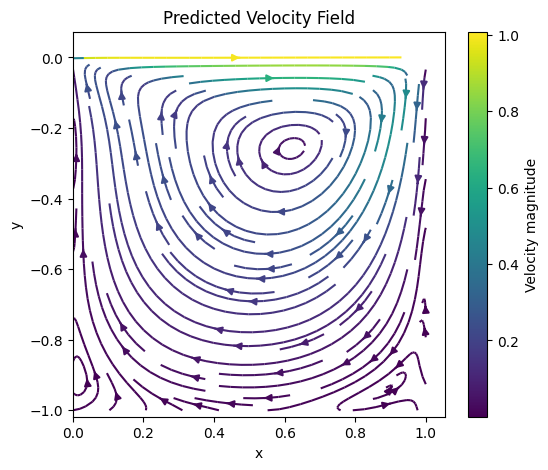

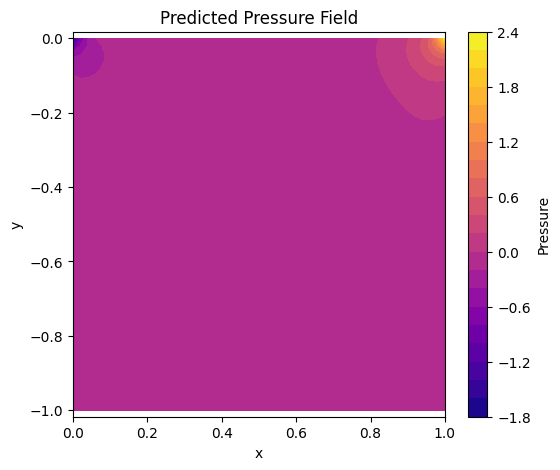

In [5]:
# === Visualization after training ===
# build meshgrid for plotting
nx, ny = 50, 50
x_vals = np.linspace(x_l, x_r, nx)
y_vals = np.linspace(y_b, y_t, ny)
X, Y = np.meshgrid(x_vals, y_vals)

# create input tensor for eval
dx_val = (x_r - x_l)/(nx-1)
dy_val = (y_t - y_b)/(ny-1)
grid_points = np.c_[X.ravel(), Y.ravel(), 
                   np.full(X.size, dx_val), 
                   np.full(Y.size, dy_val)]
grid_tensor = tf.convert_to_tensor(grid_points, dtype=tf.float32)

# predict with trained model
u_pred, v_pred, p_pred = NN.eval_point(
    grid_tensor[:,0:1], grid_tensor[:,1:2], 
    grid_tensor[:,2:3], grid_tensor[:,3:4]
)

U = u_pred.numpy().reshape(X.shape)
V = v_pred.numpy().reshape(Y.shape)
P = p_pred.numpy().reshape(X.shape)

# --- Velocity field ---
plt.figure(figsize=(6,5))
plt.streamplot(X, Y, U, V, color=np.sqrt(U**2+V**2), cmap="viridis")
plt.colorbar(label="Velocity magnitude")
plt.title("Predicted Velocity Field")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

# --- Pressure field ---
plt.figure(figsize=(6,5))
plt.contourf(X, Y, P, levels=20, cmap="plasma")
plt.colorbar(label="Pressure")
plt.title("Predicted Pressure Field")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

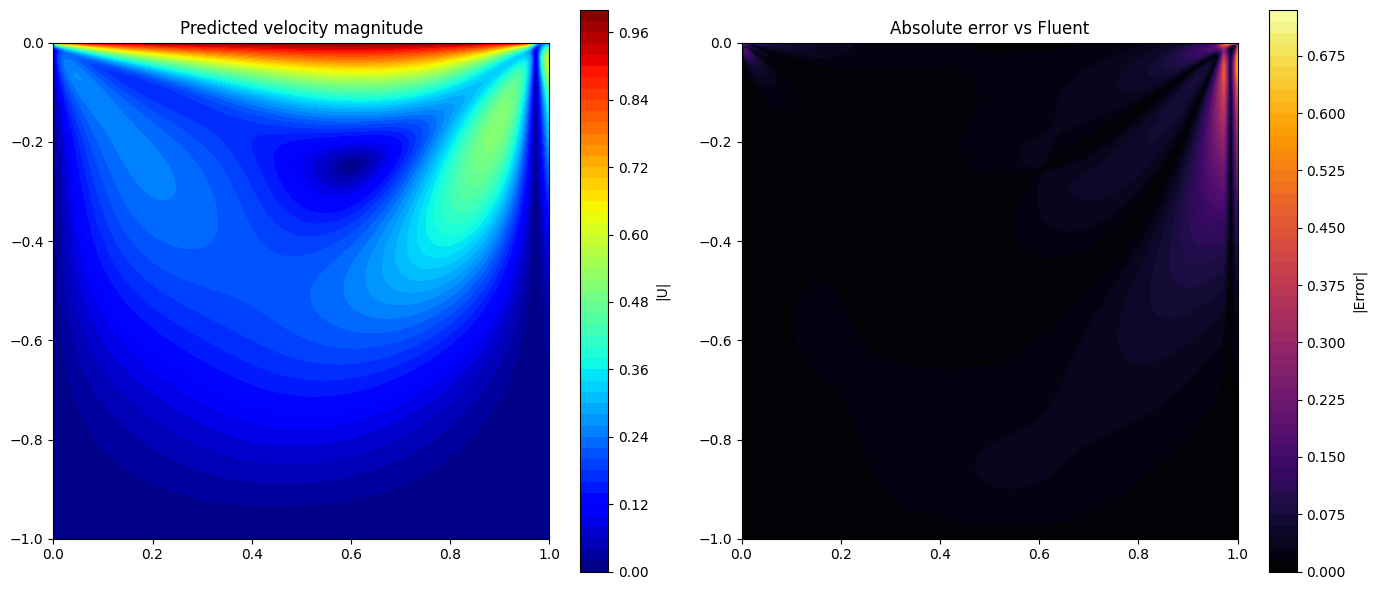

Relative L2 error norm: 1.6576e-01


In [8]:
# === Reference data (already loaded as U_true, Umag_true, X_true, Y_true) ===

# === Evaluation grid (must match reference resolution) ===
a, b = 0, 1
c, d = -1,0
shape = 252   # match with reference (252x252)
dx = 1/(shape-1)
dy = 1/(shape-1)

x = np.linspace(a, b, shape)
y = np.linspace(c, d, shape)
X, Y = np.meshgrid(x, y)

# stack test data (x,y,dx,dy)
xy_test = np.hstack((
    X.flatten()[:, None],
    Y.flatten()[:, None],
    dx*np.ones_like(X.flatten()[:, None]),
    dy*np.ones_like(Y.flatten()[:, None])
)).astype(np.float32)

# Predict with NN
U_pred, V_pred, _ = NN.eval_point(
    tf.constant(xy_test[:,0:1]),
    tf.constant(xy_test[:,1:2]),
    tf.constant(xy_test[:,2:3]),
    tf.constant(xy_test[:,3:4])
)

# reshape predictions
U_grid = U_pred.numpy().reshape(X.shape)
V_grid = V_pred.numpy().reshape(X.shape)
U_magnitude = np.sqrt(U_grid**2 + V_grid**2)

# === Compute absolute error vs Fluent ===
abs_error = np.abs(U_magnitude - Umag_true)

# === Plot ===
fig, ax = plt.subplots(1, 2, figsize=(14,6))

# PINN prediction
c1 = ax[0].contourf(X, Y, U_magnitude, levels=50, cmap="jet")
fig.colorbar(c1, ax=ax[0], label="|U|")
ax[0].set_title("Predicted velocity magnitude")
ax[0].set_aspect("equal")

# Absolute error vs Fluent
c2 = ax[1].contourf(X, Y, abs_error, levels=50, cmap="inferno")
fig.colorbar(c2, ax=ax[1], label="|Error|")
ax[1].set_title("Absolute error vs Fluent")
ax[1].set_aspect("equal")

plt.tight_layout()
plt.show()

# === Compute normalized L2 error ===
e_norm = np.sqrt(np.sum((U_magnitude - Umag_true)**2)) / np.sqrt(np.sum(Umag_true**2))
print(f"Relative L2 error norm: {e_norm:.4e}")
